# Xenon1T-2018 Limit

*Recreating (at least approximately) the Xenon1T-2018 limit, released on 28th May 2018.*

This is a very rough, first attempt at reproducing the Xenon1T-2018 limit. I'm neglecting background uncertainties and getting a simple Poisson upper limit on the number of signal events, but it gets within about a factor of 2, so it's not too bad.

In the end, including the $E_R$ (or $(S1, S2)$ information about the individual events and backgrounds would improve the limit, but using fuzzy screenshots for that is a bit of a challenge. Watch this space!

I'm using a simple spin-independent signal, but you can use the [`WIMpy` code](https://github.com/bradkav/WIMpy_NREFT) (or your own code) to generate approximate limits on non-standard operators using this script.

## Initialisation

First we'll load some standard libraries and organise `matplotlib` a bit:

In [20]:
#We'll also import some useful libraries
import numpy as np
import matplotlib.pyplot as plt

import matplotlib as mpl

font = {'family' : 'sans-serif',
        'size'   : 16}

mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.size'] = 3
mpl.rcParams['ytick.minor.width'] = 1
mpl.rc('font', **font)

from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy.stats import poisson
from scipy import optimize

Then we'll load in `WIMpy`, which is basically a spectrum generator for direct detection experiments. It is available [here](https://github.com/bradkav/WIMpy_NREFT):

In [21]:
from WIMpy import DMUtils as DMU

## Details of the experiment

In [22]:
#Nuclear recoil background:
NBG_NR_tonyr = 0.612
NBG_NR_kgday = 1.68e-6

#Electron recoil background:
NBG_ER_tonyr = 720 #+- 60
NBG_ER_tonyr = 1.97e-3 #+- 1.64e-4

#Total exposure
exp_time = 278.8 #days
exp_1300kg = 1300.0*exp_time #kg.days
exp_900kg = 900.0*exp_time #kg.days

**Recoil efficiency**

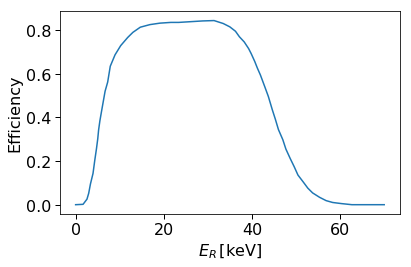

In [23]:
eff_data = np.loadtxt("Efficiency.txt")
efficiency = interp1d(eff_data[:,0], eff_data[:,1], bounds_error=False, fill_value=0.0)

plt.figure()
plt.plot(eff_data[:,0], eff_data[:,1])
plt.xlabel(r'$E_R\,[\mathrm{keV}]$')
plt.ylabel(r'Efficiency')
plt.tight_layout()
plt.savefig("plots/Efficiency.pdf")
plt.show()


## Recoil spectrum calculator

In [24]:
nuclei_Xe = ["Xe128", "Xe129", "Xe130", "Xe131", "Xe132", "Xe134", "Xe136"]

#Load in the list of nuclear spins, atomic masses and mass fractions
nuclei_list = np.loadtxt("Nuclei.txt", usecols=(0,), dtype='str')
A_list = np.loadtxt("Nuclei.txt", usecols=(1,))
frac_list = np.loadtxt("Nuclei.txt", usecols=(3,))


def get_frac(nuc):
    return float(frac_list[nuclei_list == nuc])

def get_A(nuc):
    return float(A_list[nuclei_list == nuc])

Here, the we sum over all the Xenon isotopes and return a recoil spectrum $\frac{\mathrm{d}R}{\mathrm{d}E_R}$ in units of events/kg/keV/day:

In [25]:
def calcSpectrum(E_R, m_x, sigma_p):    
    dRdE = np.zeros_like(E_R)
    
    for nuc in nuclei_Xe:
        N_p = 54.
        N_n = get_A(nuc) - N_p
        dRdE += get_frac(nuc)*DMU.dRdE_standard(E_R, N_p, N_n, m_x, sigma_p)
        
    return dRdE

Note that here, we're assuming some standard parameters for the WIMP velocity distribution. Check out the [`WIMpy` code](https://github.com/bradkav/WIMpy_NREFT) for how to adjust these parameters.

Plot a spectrum to make sure everything looks fine:

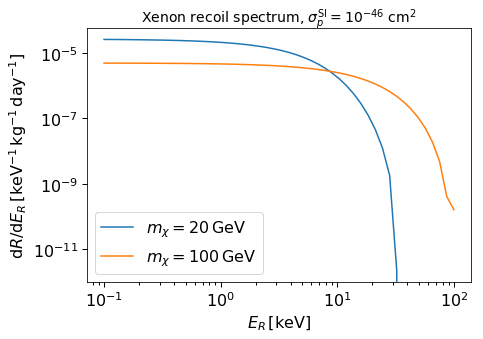

In [26]:
E_list = np.logspace(-1, 2)

plt.figure(figsize=(7,5))

plt.loglog(E_list, calcSpectrum(E_list, 20.0, 1e-46), label=r'$m_\chi = 20\,\mathrm{GeV}$')
plt.loglog(E_list, calcSpectrum(E_list, 100.0, 1e-46), label=r'$m_\chi = 100\,\mathrm{GeV}$')

plt.xlabel(r'$E_R \,[\mathrm{keV}]$')
plt.ylabel(r'$\mathrm{d}R/\mathrm{d}E_R \,[\mathrm{keV}^{-1}\,\mathrm{kg}^{-1} \,\mathrm{day}^{-1}]$')
plt.title('Xenon recoil spectrum, $\sigma_p^\mathrm{SI} = 10^{-46} \,\,\mathrm{cm}^2$', fontsize=14)

plt.legend()

plt.tight_layout()
plt.savefig("plots/Spectra.pdf")
plt.show()

## Number of signal events

Here, we'll look at the 1.3t exposure:

In [27]:
def Nevents(m_x, sigma_p):
    integrand = lambda x: efficiency(x)*calcSpectrum(x, m_x, sigma_p)
    return quad(integrand, 0, 70)[0]

In [28]:
sig0 = 1e-46

m_list = np.logspace(0, 4)
Nsig_list = exp_1300kg*np.asarray([Nevents(m, sig0) for m in m_list])

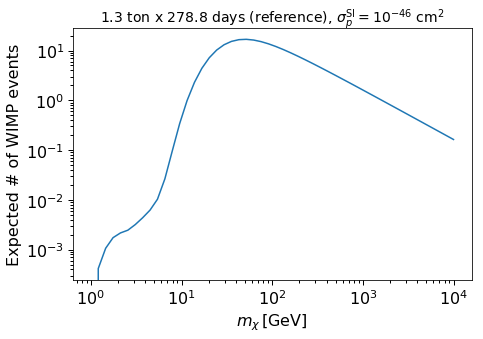

In [29]:
plt.figure(figsize=(7,5))
plt.loglog(m_list, Nsig_list)

plt.xlabel(r'$m_\chi \,[\mathrm{GeV}]$')
plt.ylabel(r'Expected # of WIMP events')

plt.title('1.3 ton x 278.8 days (reference), $\sigma_p^\mathrm{SI} = 10^{-46} \,\,\mathrm{cm}^2$', fontsize=14)

plt.tight_layout()
plt.savefig("plots/Nevents.pdf")
plt.show()

## Rough Poisson limit

Calculate 90% Poisson upper limit on the number of WIMP signal events

In [30]:
NBG = 8.40 #8.4 expected BG events
Nobs = 11.0 #11 observed events

Nsig_upper = float(optimize.root(lambda mu: poisson.ppf(0.90, mu) - Nobs, 5).x)
print("Upper limit on number of signal events is:", Nsig_upper)

Upper limit on number of signal events is: 7.138783269961977


Now we take the number of signal events as a function of DM mass and rescale to give `Nsig_upper`:

In [31]:
sig_UL = sig0*Nsig_upper/Nsig_list

/Users/bradkav/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


Now we plot:

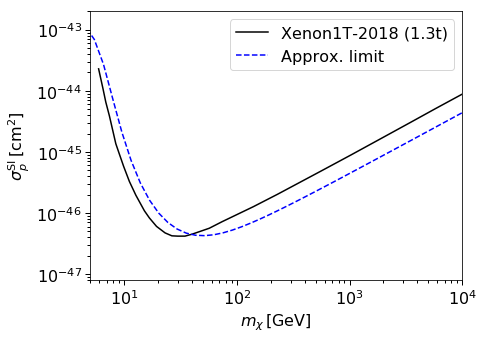

In [32]:
m1, lim1 = np.loadtxt("Xenon1T-2018-limit.txt", unpack=True)

plt.figure(figsize=(7,5))

plt.loglog(m1, lim1, 'k-', label="Xenon1T-2018 (1.3t)")
plt.loglog(m_list, sig_UL, 'b--', label="Approx. limit")


plt.xlim(5, 1e4)
plt.ylim(8e-48, 2e-43)

plt.xlabel(r'$m_\chi \,[\mathrm{GeV}]$')
plt.ylabel(r'$\sigma_p^\mathrm{SI} \,[\mathrm{cm}^2]$')

plt.legend()
plt.tight_layout()
plt.savefig("plots/Limit.pdf")
plt.show()

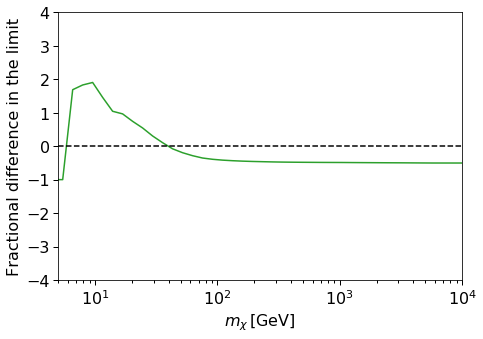

In [33]:
XenonLim = interp1d(m1, lim1, bounds_error=False, fill_value = 1e10)


plt.figure(figsize=(7,5))

plt.semilogx(m_list, (sig_UL-XenonLim(m_list))/XenonLim(m_list), 'C2')

plt.axhline(0, linestyle='--', color='k')

plt.xlim(5, 1e4)
plt.ylim(-4, 4)

plt.xlabel(r'$m_\chi \,[\mathrm{GeV}]$')
plt.ylabel(r'Fractional difference in the limit')

plt.tight_layout()
plt.savefig("plots/Comparison.pdf")
plt.show()

In the end, the simple Poisson limit is within about a factor of 2 of the 'true' limit. 

A few caveats:
* I wouldn't trust the limit at very low WIMP mass. Here, the specifics of the efficiency are very important, as are the full $(S1, S2)$ distribution of the events. But above about 10 GeV it should be fine.
* I don't include any spectral information about the observed events. The observed events are at high-ish recoil energy, pointing towards a heavy (> 100 GeV) WIMP if they are due to signal. This means that my limit is a little weaker at low WIMP mass than the true limit (which knows that the 'signal' events *don't* look like a light WIMP) and a little stronger at high WIMP mass. When we get more information, we can improve things. 